<a href="https://colab.research.google.com/github/LauraGeiger/Cerebellar-Learning/blob/main/NEURON_Cerebellar_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neuron

In [ ]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

In [16]:
class STDP: # Spike timing dependent plasticity
    def __init__(self, netcon):
        self.netcon = netcon
        self.weight = netcon.weight[0]  # Synaptic weight
        self.pre_times = []
        self.post_times = []
        self.dt_LTP = 10  # Time window for LTP (ms)
        self.dt_LTD = -10  # Time window for LTD (ms)
        self.A_plus = 0.005  # LTP increment
        self.A_minus = -0.005  # LTD decrement
        self.tau_stdp = 20 # range of pre-to-postsynaptic interspike intervals over which synaptic strengthening or weakening occurs
        self.weight_changes = []

    def pre_spike(self, t):
        #print(f"Pre-synaptic spike at {t} ms")
        self.pre_times.append(t)
        self.update_weights()

    def post_spike(self, t):
        #print(f"Post-synaptic spike at {t} ms")
        self.post_times.append(t)
        self.update_weights()

    def update_weights(self):
        if len(self.pre_times) > 0 and len(self.post_times) > 0:
            dt = self.post_times[-1] - self.pre_times[-1]  # Time difference

            if dt > 0 and dt < self.dt_LTP:  # LTP Condition
                dW = self.A_plus * (max_weight - self.weight) # dependent on current weight
                #dW = self.A_plus * np.exp(dt / self.tau_stdp) # dependent on timing
                print("LTP: ", dW)
                self.weight += dW
            elif dt < 0 and dt > self.dt_LTD:  # LTD Condition
                dW = self.A_minus * self.weight # dependet on current weight
                #dW = self.A_minus * np.exp(dt / self.tau_stdp) # dependent on timing
                print("LTD: ", dW)
                self.weight += dW

            self.weight = max(0, min(self.weight, max_weight))  # Keep weight within limits
            self.netcon.weight[0] = self.weight
            self.weight_changes.append((h.t, self.weight))


LTD:  -5e-05
LTP:  0.00045025
LTD:  -5.200125e-05
Pre-spike times: [20.925000000099345, 42.900000000101194, 61.900000000105514]
Post-spike times: [15.92500000009963, 45.92500000010188, 57.17500000010444]


<Figure size 1000x500 with 0 Axes>

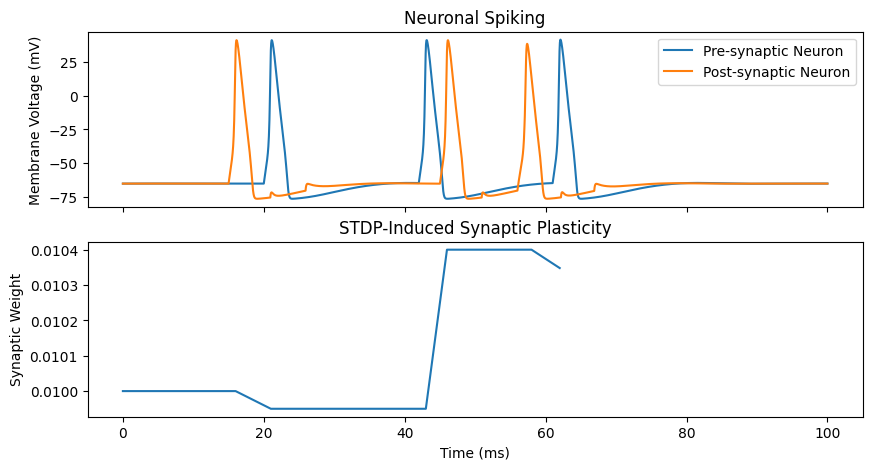

In [18]:
# Create pre- and post-synaptic neurons
pre_neuron = h.Section(name='pre_neuron')
post_neuron = h.Section(name='post_neuron')

#h.topology()
h.load_file("nrngui.hoc")
shape_window = h.PlotShape(True)  # Enable shape visualization
shape_window.show(0)  # Show all sections

# Set neuron properties
for sec in [pre_neuron, post_neuron]:
    sec.L = sec.diam = 20  # Soma
    sec.insert('hh')  # Hodgkin-Huxley channels

# Create a synapse on the post-neuron
syn = h.ExpSyn(post_neuron(0.5))
#syn.tau = 2  # Rise time (ms)
#syn.tau2 = 5  # Decay time (ms)
syn.e = 0  # Reversal potential (mV)

# Connect the neurons with a NetCon
initial_weight = 0.01
max_weight = 0.1
delay = 5 # Delay in ms
pre_netcon = h.NetCon(pre_neuron(0.5)._ref_v, syn, sec=pre_neuron)
pre_netcon.weight[0] = initial_weight  # Initial synaptic weight
pre_netcon.delay = delay
post_netcon = h.NetCon(post_neuron(0.5)._ref_v, syn, sec=post_neuron)
post_netcon.weight[0] = initial_weight  # Initial synaptic weight
post_netcon.delay = delay



stdp = STDP(pre_netcon)

# Record spikes
pre_spikes = h.Vector()
post_spikes = h.Vector()

pre_netcon.record(pre_spikes)
post_netcon.record(post_spikes)

# Stimulate Pre-Synaptic Neuron
stim_pre = h.IClamp(pre_neuron(0.5))
stim_pre.delay = 20
stim_pre.dur = 1
stim_pre.amp = 0.5

stim_pre2 = h.IClamp(pre_neuron(0.5))
stim_pre2.delay = 42
stim_pre2.dur = 1
stim_pre2.amp = 0.5

stim_pre3 = h.IClamp(pre_neuron(0.5))
stim_pre3.delay = 61
stim_pre3.dur = 1
stim_pre3.amp = 0.5

# Stimulate Post-Synaptic Neuron (to induce pairing)
stim_post = h.IClamp(post_neuron(0.5))
stim_post.delay = 15  # Post fires shortly after Pre to induce LTP
stim_post.dur = 1
stim_post.amp = 0.5

stim_post2 = h.IClamp(post_neuron(0.5))
stim_post2.delay = 45
stim_post2.dur = 1
stim_post2.amp = 0.5

stim_post3 = h.IClamp(post_neuron(0.5))
stim_post3.delay = 56
stim_post3.dur = 1
stim_post3.amp = 0.5

# Record voltage and weight changes
t = h.Vector().record(h._ref_t)
v_pre = h.Vector().record(pre_neuron(0.5)._ref_v)
v_post = h.Vector().record(post_neuron(0.5)._ref_v)


# Run simulation
h.finitialize(-65)

# Continuously run the simulation and update weights during the simulation
while h.t < 100:
    h.continuerun(h.t + 1)  # Incrementally run the simulation
    # Call pre_spike and post_spike whenever spikes are detected
    for t_spike in pre_spikes:
        #print("t_spike ", t_spike)
        #print("h.t ", h.t)
        if (t_spike > h.t-1): # only process newly detected spikes
          stdp.pre_spike(t_spike)

    for t_spike in post_spikes:
        if (t_spike > h.t-1): # only process newly detected spikes
          stdp.post_spike(t_spike)

# Convert data to NumPy arrays
t_np = np.array(t)
v_pre_np = np.array(v_pre)
v_post_np = np.array(v_post)
weights = np.array(stdp.weight_changes)


# Add initial weight at time 0ms until (first weight_change - delay)
init_weight_start = np.array([[0, initial_weight]])
init_weight_end = np.array([[weights[0,0] - delay, initial_weight]])
weights = np.vstack([init_weight_start, init_weight_end, weights])

print("Pre-spike times:", list(pre_spikes))
print("Post-spike times:", list(post_spikes))
#print("Weights:", weights)

# Plot Voltage Traces
plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
#plt.subplot(2,1,1)
ax1.plot(t_np, v_pre_np, label="Pre-synaptic Neuron")
ax1.plot(t_np, v_post_np, label="Post-synaptic Neuron")
ax1.legend()
ax1.set_ylabel("Membrane Voltage (mV)")
ax1.set_title("Neuronal Spiking")

# Plot Synaptic Weight Changes
if len(weights) > 0:
  #ax2.subplot(2,1,2)
  ax2.plot(weights[:,0], weights[:,1])
  ax2.set_xlabel("Time (ms)")
  #ax2.set_ylim(bottom=0.0098)
  #ax2.set_ylim(top=0.0101)
  ax2.set_ylabel("Synaptic Weight")
  ax2.set_title("STDP-Induced Synaptic Plasticity")
else:
    print("No weight changes recorded!")

#plt.tight_layout()
plt.show()

